In [117]:
using Unitful #https://painterqubits.github.io/Unitful.jl/stable/
#quantity * @u_str("unit abbreviation") 
using Symbolics #https://symbolics.juliasymbolics.org/dev/
#cite https://doi.org/10.48550/arXiv.2105.03949
using Latexify
using Test
#1 * @u_str("mA") is 1 milliamp
using CSV, DataFrames
#using Plots
using PlotlyJS
using SymPy
using Interpolations
using Plots
using Interact
using Statistics
using PlotlyBase
#plotlyjs()
data_dir = "C:\\Cross-Section-Data\\EXFOR\\"

"C:\\Cross-Section-Data\\EXFOR\\"

#Design

    Looping check_line() through each line in the file detects where each dataset begins. 

    Reading the line above each output of check_line() gives the number of rows in each dataset.

    make_spacing_dict() gets the names of the columns and the instructions for how to read each dataset.

    read_dataset() reads each and constructs a dictionary from each dataset.
    
    read_exfor_file() runs all of the above in order to return a single DataFrame of all the data stored at a given file path.
     

In [23]:
replace("Refer (YY)", " " => "", "(" => "", ")" => "")

"ReferYY"

In [24]:
function check_line(line, start)
    if length(line) > length(start) - 1
        return (line[1:length(start)] == start)
    end
    return false
end

function make_spacing_dict(line1, line2)
    spacing_ends = [collect(out)[1] for out in findall(">", line2)]
    spacing_starts = append!([1], [collect(out)[1] for out in findall("<", line2)])
    #Find where some of the spacings begin and end based on the arrows
    if length(spacing_ends) != length(spacing_starts)
        print("Error: improper formatting")
        return 
    end
    indices_with_gaps = [index for index in  1:length(spacing_ends)-1 if 
                    spacing_ends[index] != spacing_starts[index+1]-1]
    #Some of the spacings are instead denoted by the letter o instead of arrows
    missing_spacings = [spacing_ends[index]+1:spacing_starts[index+1]-1 for index in indices_with_gaps]
    spacings = append!(missing_spacings, 
    [spacing_starts[i]:spacing_ends[i] for i in 1:length(spacing_ends)])
    spacing_dict = Dict([])
    replace_dict = 
    #Make a dictionary where the keys are name for each column and the values are the indices of the columns
    spacing_names = [spacing_dict[replace(strip(line1[spacing], [' ', '#']),
                     " " => "", "(" => "", ")" => "")] = 
                        spacing for spacing in spacings]
    return spacing_dict
end

function read_datum(datum)
    #Reads a single datum from a line of data
    datum = strip(datum, [' '])
    out = tryparse(Float64, datum)
    if out == nothing
        return datum 
    end
    return out
end

read_datum (generic function with 1 method)

In [25]:
function check_spacings(file_path)
    #Reads an EXFOR file and returns a dictionary of data
    file_as_vector = readlines(file_path)
    spacing_specifiers = [index for index in 1:length(file_as_vector) 
                        if check_line(file_as_vector[index], "# Prj")]
    if spacing_specifiers == []
        print("Error: no data found")
        return
    end
    list_spacing_dict = [make_spacing_dict(file_as_vector[spacing_specifier], 
                                            file_as_vector[spacing_specifier+1])
                        for spacing_specifier in spacing_specifiers]
    #check if the spacing dicts are the same
    for index in 2:length(spacing_specifiers)
        if list_spacing_dict[index] != list_spacing_dict[1]
            return false
        end
    end
    return true
end

check_spacings (generic function with 1 method)

In [26]:
subdirs = [content * "\\" for content in readdir(data_dir) if isdir(data_dir * "\\" * content)]
for subdir in subdirs
    files = readdir(data_dir * subdir)
    test = [check_spacings(data_dir * subdir * file) for file in files]
    println("It is ", all(test),
     " that the spacings in each file are all self consistent for the subdirectory ", subdir)
end

It is true that the spacings in each file are all self consistent for the subdirectory alphas\
It is true that the spacings in each file are all self consistent for the subdirectory deuterons\
It is true that the spacings in each file are all self consistent for the subdirectory gammas\
It is true that the spacings in each file are all self consistent for the subdirectory helions\
It is true that the spacings in each file are all self consistent for the subdirectory neutrons\
It is true that the spacings in each file are all self consistent for the subdirectory other\
It is true that the spacings in each file are all self consistent for the subdirectory protons\


So I only need to retrieve the spacings of the data once for each file. 

In [27]:
function read_exfor_file(file_path, MTs)
    #Reads an EXFOR file and returns a dictionary of data
    file_as_vector = readlines(file_path)
    spacing_specifiers = [index for index in 1:length(file_as_vector) 
                            if check_line(file_as_vector[index], "# Prj") && 
                                tryparse(Int64, file_as_vector[index-5][5:end]) 
                                in MTs]
    if spacing_specifiers == []
        print("Error: no data found")
        return
    end
    dataset_rows = [tryparse(Int64, split(file_as_vector[index - 1], [' '])[end])
                            for index in spacing_specifiers]
    #Each dataset should have the same column names
    spacing_dict = make_spacing_dict(file_as_vector[spacing_specifiers[1]], 
                    file_as_vector[spacing_specifiers[1] + 1])
    #make an empty dataframe to fill up with the data
    df = DataFrame([Vector{Union{Missing, Float64, String, SubString{String}}}(
                missing, sum(dataset_rows)) 
                   for _ in 1:length(keys(spacing_dict))], 
                   [key for key in keys(spacing_dict)])
    #make a nested vector, then flatten it to populate the dataframe.
    _ = [df[:,key] = collect(Iterators.flatten([[read_datum(
                    file_as_vector[line_num][spacing_dict[key]]) 
                    for line_num in spacing_specifiers[index] + 2: 
                            spacing_specifiers[index] + 1 + dataset_rows[index]]
                            for index in 1:length(spacing_specifiers)]))
                    for key in keys(spacing_dict)]           
    return df
end

read_exfor_file (generic function with 1 method)

In [46]:
file_path = data_dir * "neutrons\\092_U_238.c4"
MT_102_df = read_exfor_file(file_path, [102])
MT_2_df = read_exfor_file(file_path, [2]);

Instead of filtering by MTs when I look at the data, what if I only filtered by MT when I plot it? 

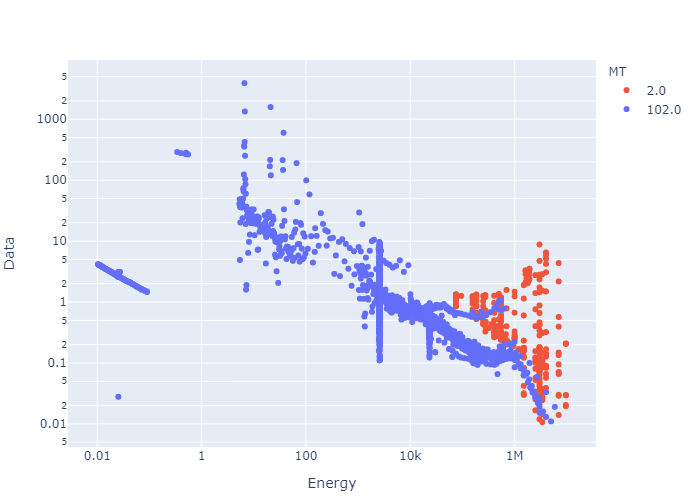

In [29]:
fig = PlotlyJS.plot(df, x=:Energy, y=:Data, color=:MT, text=:ReferYY,
                mode="markers", Layout(yaxis_type="log", xaxis_type="log"))

In [12]:
function upload_plot(fig, plot_name)
    open("./" * plot_name * ".html", "w") do io

        PlotlyBase.to_html(io, fig.plot)

    end
end

upload_plot (generic function with 1 method)

Write script that adds the correct URL in urls.py, makes a new entry to the list on index.html, and a function views.py to render the plot. 

https://interactive-data-mp7635.herokuapp.com/neutrons-U238

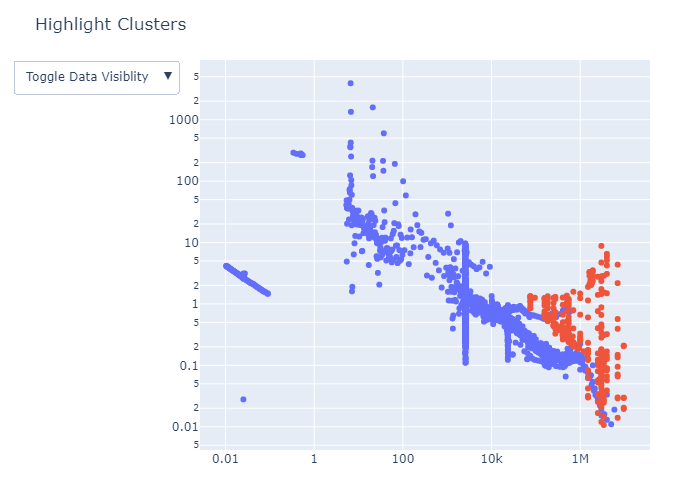

In [178]:
using Distributions

trace1 = PlotlyJS.scatter(MT_102_df, x=:Energy, y=:Data, color=:MT, text=:ReferYY,
                            mode="markers")
trace2 = PlotlyJS.scatter(MT_2_df, x=:Energy, y=:Data, color=:MT, text=:ReferYY,
                            mode="markers")

layout = Layout(
    updatemenus=[
        attr(
            buttons=[
                attr(label="Toggle Data Visiblity",
                    method="restyle",
                    args=[Dict(:visible => true)],
                    args2=[Dict(:visible => false)])
            ],
        )
    ],
    title_text="Highlight Clusters",
    showlegend=false,
    yaxis_type="log", xaxis_type="log"
)

fig = PlotlyJS.plot([trace1, trace2], layout)
fig

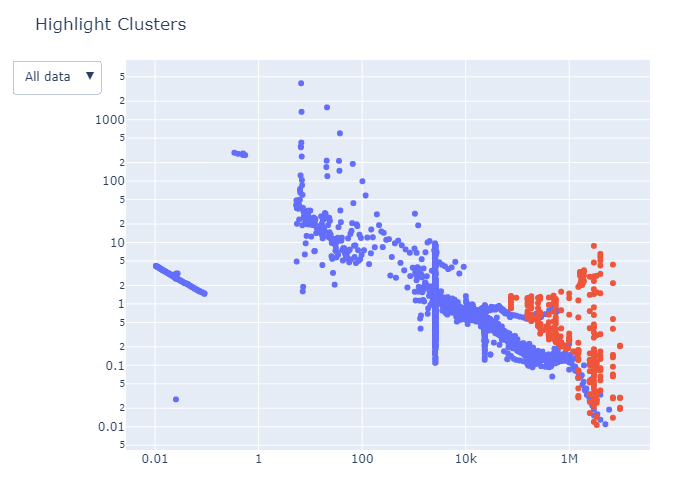

In [157]:
restyle!(fig, [2], visible=[true])
fig

In [108]:
upload_plot(fig, "example")

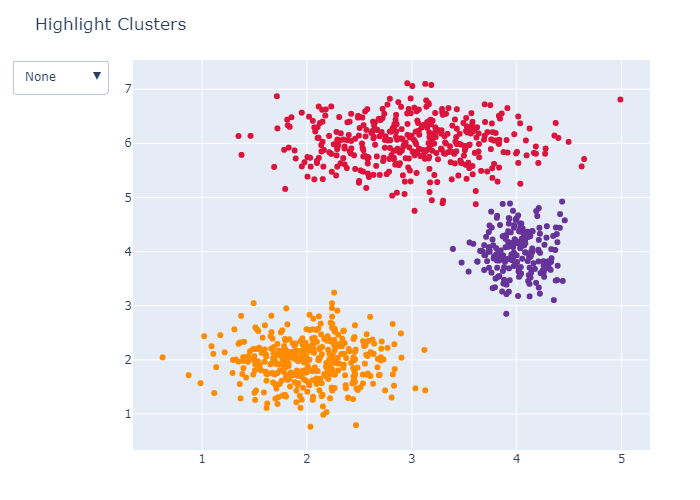

In [76]:
using PlotlyJS, Distributions

x0 = rand(Normal(2, 0.4), 400)
y0 = rand(Normal(2, 0.4), 400)
x1 = rand(Normal(3, 0.6), 600)
y1 = rand(Normal(6, 0.4), 400)
x2 = rand(Normal(4, 0.2), 200)
y2 = rand(Normal(4, 0.4), 200)

trace1 = PlotlyJS.scatter(x=x0, y=y0, mode="markers", marker_color="DarkOrange")
trace2 = PlotlyJS.scatter(x=x1, y=y1, mode="markers", marker_color="Crimson")
trace3 = PlotlyJS.scatter(x=x2, y=y2, mode="markers", marker_color="RebeccaPurple")

# Add buttons that add markers
cluster0 = [attr(type="circle",
                            xref="x", yref="y",
                            x0=minimum(x0), y0=minimum(y0),
                            x1=maximum(x0), y1=maximum(y0),
                            line=attr(color="DarkOrange"))]
cluster1 = [attr(type="circle",
                            xref="x", yref="y",
                            x0=minimum(x1), y0=minimum(y1),
                            x1=maximum(x1), y1=maximum(y1),
                            line=attr(color="Crimson"))]
cluster2 = [attr(type="circle",
                            xref="x", yref="y",
                            x0=minimum(x2), y0=minimum(y2),
                            x1=maximum(x2), y1=maximum(y2),
                            line=attr(color="RebeccaPurple"))]

layout = Layout(
    updatemenus=[
        attr(
            buttons=[
                attr(label="None",
                    method="relayout",
                    args=["shapes", []]),
                attr(label="Cluster 0",
                    method="relayout",
                    args=["shapes", cluster0]),
                attr(label="Cluster 1",
                    method="relayout",
                    args=["shapes", cluster1]),
                attr(label="Cluster 2",
                    method="relayout",
                    args=["shapes", cluster2]),
                attr(label="All",
                    method="relayout",
                    args=["shapes", vcat(cluster0, cluster1, cluster2)])
            ],
        )
    ],
    title_text="Highlight Clusters",
    showlegend=false
)

fig = PlotlyJS.plot([trace1, trace2, trace3], layout)

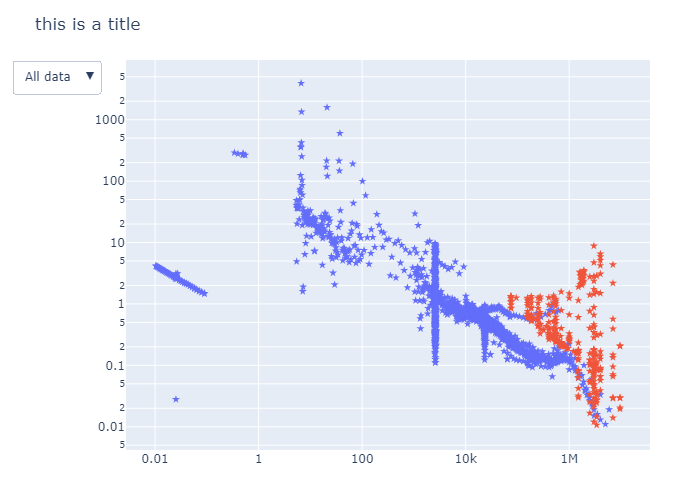

In [81]:
update!(fig, Dict(:marker => Dict(:color => "none")), layout=Layout(title="this is a title"), marker_symbol="star")
fig

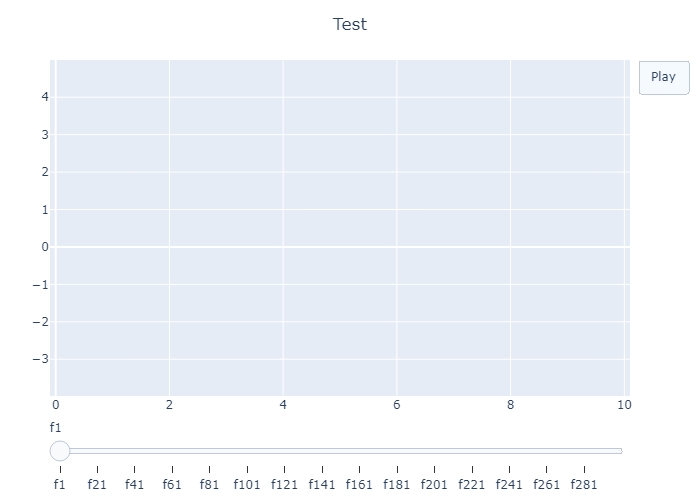

In [181]:

N=300
X = LinRange(0, 10, N)
Y = -3 .+ 7*rand(N)

trace = PlotlyJS.scatter(x = [X[1]],  
                y = [Y[1]],
                mode="lines",
                line_width=1.5,
                line_color="RoyalBlue")

n_frames = length(X)
frames  = Vector{PlotlyFrame}(undef, n_frames)
for k in 1:n_frames
    frames[k] = PlotlyBase.frame(data=[attr(x=X[1:k], #update x and y
                                 y=Y[1:k],
                                 )],
                      layout=attr(title_text="Test frame $k"), #update title
                      name="fr$k", #frame name; it is passed to slider 
                      traces=[0] 
                      # this means that the above data update the first trace (here the unique one) 
                        ) 
end    


updatemenus = [attr(type="buttons", 
                    active=0,
                    y=1,  #(x,y) button position 
                    x=1.1,
                    buttons=[attr(label="Play",
                                  method="animate",
                                  args=[nothing,
                                        attr(frame=attr(duration=5, 
                                                        redraw=true),
                                             transition=attr(duration=0),
                                             fromcurrent=true,
                                             mode="immediate"
                                                        )])])];


sliders = [attr(active=0, 
                minorticklen=0,
                
                steps=[attr(label="f$k",
                            method="animate",
                            args=[["fr$k"], # match the frame[:name]
                                  attr(mode="immediate",
                                       transition=attr(duration=0),
                                       frame=attr(duration=5, 
                                                  redraw=true))
                                 ]) for k in 1:n_frames ]
             )];    

ym, yM = extrema(Y)
layout = Layout(title_text="Test", title_x=0.5,
    width=700, height=450,
              xaxis_range=[-0.1, 10.1], 
              yaxis_range=[ym-1, yM+1],
              updatemenus=updatemenus,
              sliders=sliders
    )
pl = Plot(trace, layout, frames)